In [2]:
import math,adjustText
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd 

### curve
def hanging_line(point1, point2):
    a = (point2[1] - point1[1])/(np.cosh(point2[0]) - np.cosh(point1[0]))
    b = point1[1] - a*np.cosh(point1[0])
    x = np.linspace(point1[0], point2[0], 100)
    y = a*np.cosh(x) + b
    return (x,y)

In [3]:
import scanpy as sc
adata=sc.read_h5ad('data/20220420_adata_final.h5ad')


In [4]:
Plot_Rank4 = 'Di- and mesencephalon excitatory neurons'

In [5]:
adata_sub = adata[adata.obs['Rank4_Defined'] == Plot_Rank4,:].copy()

In [6]:
intersect_gene = np.intersect1d(adata_sub.raw.var.index, adata_sub.var.index)
adata_sub_raw_X = adata_sub.raw[:,intersect_gene].X

maxRNAcount=np.array(adata_sub_raw_X).max(axis=0)
adata_sub=adata_sub[:,intersect_gene][:,maxRNAcount>10]

In [7]:
# Run PCA
sc.tl.pca(adata_sub, n_comps =50,svd_solver='arpack')
sc.pp.neighbors(adata_sub, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata_sub)
sc.tl.leiden(adata_sub, resolution=0.5)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [8]:
cluster_pl=list(np.random.rand(len(adata_sub.obs['Rank5_Symbol'] .unique()),3))


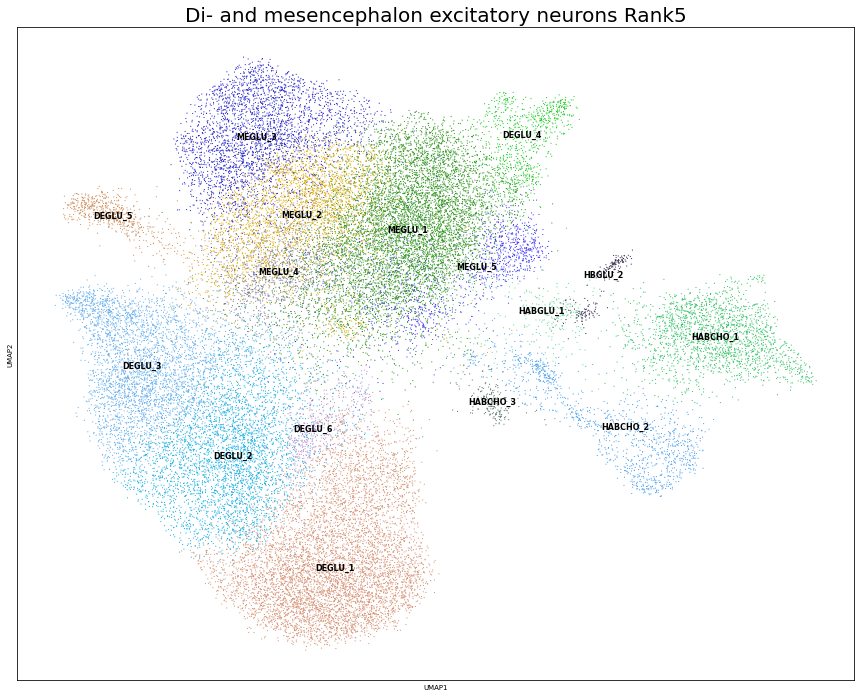

In [9]:
fig,ax = plt.subplots(figsize=(15,12))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(7)
ax=sc.pl.umap(adata_sub,size=5, 
              legend_loc='on data',color='Rank5_Symbol',
              legend_fontsize=8,
              palette = cluster_pl,
              ax=ax,show=False)
ax.set_title(Plot_Rank4 + ' Rank5')
ax.title.set_fontsize(20)
# fig.savefig(Plot_Rank4 + 'UMAP_full.png',dpi = 300)

In [13]:
adata_sub.obs['leiden'] = adata_sub.obs['Rank5_Symbol'] 

X_umap_loc=adata_sub.obsm['X_umap']
leiden_umapcenter=pd.DataFrame(data={'leiden':[],'loc_1':[],'loc_2':[]})
leiden_width=pd.DataFrame(data={'leiden1':[],'leiden2':[],
                                'width_1':[]})

fig, ax = plt.subplots(figsize=(10,10),dpi=300)

unique_leiden = list(adata_sub.obs['leiden'].unique())
plt.scatter(adata_sub.obsm['X_umap'][:,0],
            adata_sub.obsm['X_umap'][:,1],
            s=1,
            c=[cluster_pl[unique_leiden.index(i)] for i in adata_sub.obs['leiden']]
            )

#plot points and text
texts = []
for ind,i in enumerate(adata_sub.obs['leiden'].unique()):
    leiden_i_point=X_umap_loc[adata_sub.obs['leiden']==i,:]
    
    #find connection with 10-nn
    knn = NearestNeighbors(n_neighbors=10).fit(X_umap_loc)
    distances, indices = knn.kneighbors(leiden_i_point)
    pct_ofknn=pd.value_counts(adata_sub.obs['leiden'][np.ravel(indices)])/np.ravel(indices).shape[0]
    knn_0_03=pct_ofknn#[pct_ofknn>0.03]
    for indj,j in enumerate(knn_0_03.index):
#         print(indj,j,knn_0_03[indj])
        leiden_width=leiden_width.append({'leiden1':i,'leiden2':j,'width_1':knn_0_03[indj]},ignore_index=True)

    #find center
    i_loc=np.mean(leiden_i_point, axis=0)
    leiden_umapcenter=leiden_umapcenter.append({'leiden':i,'loc_1':i_loc[0],'loc_2':i_loc[1]},ignore_index=True)

flag=1
#plot connections
for ind,i in enumerate(adata_sub.obs['leiden'].unique()):
    i_knn=leiden_width.loc[leiden_width['leiden1']==i,:]
    i_knn=i_knn.loc[i_knn['width_1']>0.03,:]
    for indj,j in enumerate(i_knn['leiden2']):
        if i!=j:
            test=leiden_width.loc[((leiden_width['leiden1']==j) & (leiden_width['leiden2']==i))]
#             print(ind,i,i_knn.iloc[indj,:]['width_1'],indj,j,test['width_1'])
            
            point1=[leiden_umapcenter.loc[leiden_umapcenter['leiden']==i,:]['loc_1'].iloc[0],
                   leiden_umapcenter.loc[leiden_umapcenter['leiden']==i,:]['loc_2'].iloc[0]]

            point2=[leiden_umapcenter.loc[leiden_umapcenter['leiden']==j,:]['loc_1'].iloc[0],
                    leiden_umapcenter.loc[leiden_umapcenter['leiden']==j,:]['loc_2'].iloc[0]]            
            point1_width=i_knn.iloc[indj,:]['width_1']
            point2_width=test.iloc[0,:]['width_1']
            
            if flag==1:
                print(i,i_knn.iloc[indj,:]['width_1'],j,test.iloc[0,:]['width_1'])
                flag=0
            x,y = hanging_line(point1, point2)

            lwidths=[20*(point1_width+x*(point2_width-point1_width)/999) for x in (range(1000))]
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, linewidths=lwidths,color='gray')
            ax.add_collection(lc)
            leiden_width=leiden_width.drop(index=test.index[0])

            
for ind,i in enumerate(adata_sub.obs['leiden'].unique()):
    leiden_i_point=X_umap_loc[adata_sub.obs['leiden']==i,:]   
    i_loc=np.mean(leiden_i_point, axis=0)
    ax.scatter(i_loc[0],i_loc[1],color=cluster_pl[ind],s=math.log(leiden_i_point.shape[0])*20,edgecolor=None,zorder=2)
    texts.append(ax.text(i_loc[0],i_loc[1], i ))   
adjustText.adjust_text(texts)

ax.set_xticks([])
ax.set_yticks([])
fig.show()
# fig.savefig('ConstellationPlot_full.png')

Output hidden; open in https://colab.research.google.com to view.

In [17]:
adata_sub.obs['leiden'] = adata_sub.obs['Rank5_Symbol'] 

X_umap_loc=adata_sub.obsm['X_umap']
leiden_umapcenter=pd.DataFrame(data={'leiden':[],'loc_1':[],'loc_2':[]})
leiden_width=pd.DataFrame(data={'leiden1':[],'leiden2':[],
                                'width_1':[]})

fig, ax = plt.subplots(figsize=(10,10),dpi=300)

unique_leiden = list(adata_sub.obs['leiden'].unique())
plt.scatter(adata_sub.obsm['X_umap'][:,0],
            adata_sub.obsm['X_umap'][:,1],
            s=1,
            c=[cluster_pl[unique_leiden.index(i)] for i in adata_sub.obs['leiden']]
            )

#plot points and text
texts = []
for ind,i in enumerate(adata_sub.obs['leiden'].unique()):
    leiden_i_point=X_umap_loc[adata_sub.obs['leiden']==i,:]
    
    #find connection with 10-nn
    knn = NearestNeighbors(n_neighbors=10).fit(X_umap_loc)
    distances, indices = knn.kneighbors(leiden_i_point)
    pct_ofknn=pd.value_counts(adata_sub.obs['leiden'][np.ravel(indices)])/np.ravel(indices).shape[0]
    knn_0_03=pct_ofknn#[pct_ofknn>0.03]
    for indj,j in enumerate(knn_0_03.index):
#         print(indj,j,knn_0_03[indj])
        leiden_width=leiden_width.append({'leiden1':i,'leiden2':j,'width_1':knn_0_03[indj]},ignore_index=True)

    #find center
    i_loc=np.mean(leiden_i_point, axis=0)
    leiden_umapcenter=leiden_umapcenter.append({'leiden':i,'loc_1':i_loc[0],'loc_2':i_loc[1]},ignore_index=True)

flag=1
#plot connections
for ind,i in enumerate(adata_sub.obs['leiden'].unique()):
    i_knn=leiden_width.loc[leiden_width['leiden1']==i,:]
    i_knn=i_knn.loc[i_knn['width_1']>0.03,:]
    for indj,j in enumerate(i_knn['leiden2']):
        if i!=j:
            test=leiden_width.loc[((leiden_width['leiden1']==j) & (leiden_width['leiden2']==i))]
#             print(ind,i,i_knn.iloc[indj,:]['width_1'],indj,j,test['width_1'])
            
            point1=[leiden_umapcenter.loc[leiden_umapcenter['leiden']==i,:]['loc_1'].iloc[0],
                   leiden_umapcenter.loc[leiden_umapcenter['leiden']==i,:]['loc_2'].iloc[0]]

            point2=[leiden_umapcenter.loc[leiden_umapcenter['leiden']==j,:]['loc_1'].iloc[0],
                    leiden_umapcenter.loc[leiden_umapcenter['leiden']==j,:]['loc_2'].iloc[0]]            
            point1_width=i_knn.iloc[indj,:]['width_1']
            point2_width=test.iloc[0,:]['width_1']
            
            if flag==1:
                print(i,i_knn.iloc[indj,:]['width_1'],j,test.iloc[0,:]['width_1'])
                flag=0
            x,y = hanging_line(point1, point2)

            lwidths=[20*(point1_width+x*(point2_width-point1_width)/999) for x in (range(1000))]
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, linewidths=lwidths,color='gray')
            ax.add_collection(lc)
            leiden_width=leiden_width.drop(index=test.index[0])

            
for ind,i in enumerate(adata_sub.obs['leiden'].unique()):
    leiden_i_point=X_umap_loc[adata_sub.obs['leiden']==i,:]   
    i_loc=np.mean(leiden_i_point, axis=0)
    # ax.scatter(i_loc[0],i_loc[1],color='k',s=math.log(leiden_i_point.shape[0])*20,edgecolor=None,zorder=2,facecolors='none')
    texts.append(ax.text(i_loc[0],i_loc[1], i ))   
adjustText.adjust_text(texts)

ax.set_xticks([])
ax.set_yticks([])
fig.show()
# fig.savefig('ConstellationPlot_full.png')

Output hidden; open in https://colab.research.google.com to view.

Constellation Plot

MEGLU_5 0.33101933216168716 MEGLU_1 0.05296039199673336


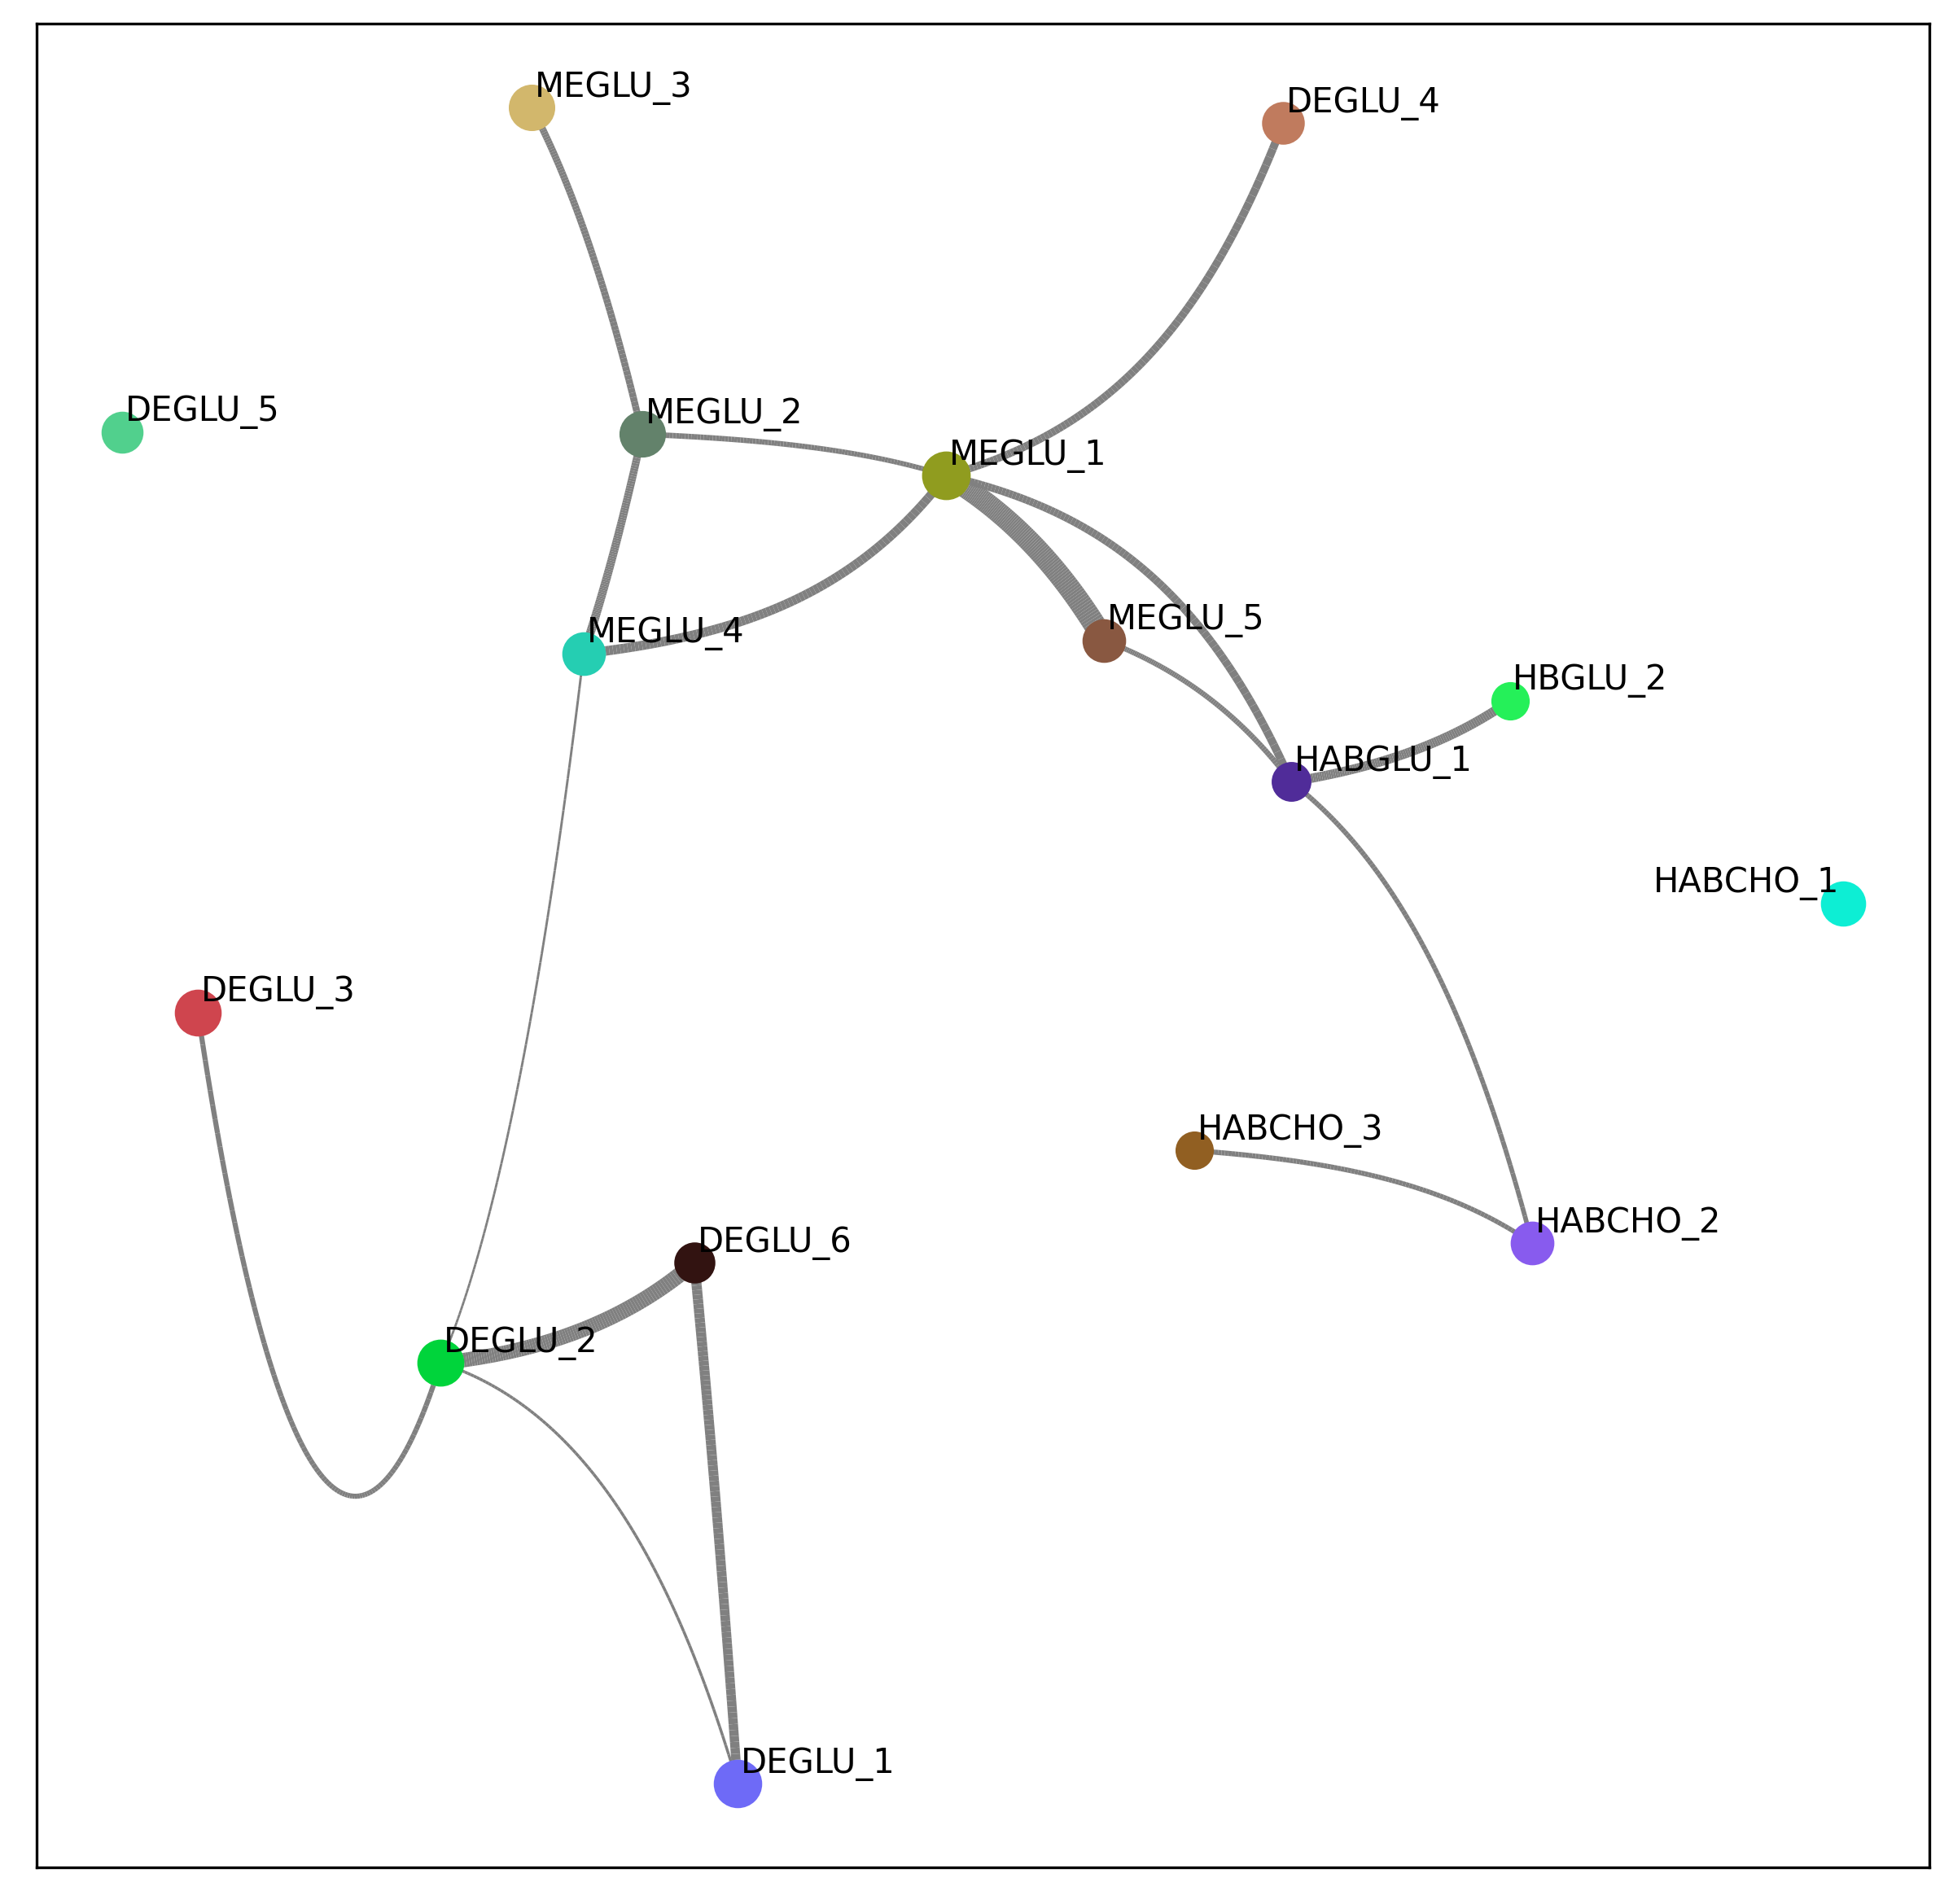

In [ ]:
adata_sub.obs['leiden'] = adata_sub.obs['Rank5_Symbol'] 

X_umap_loc=adata_sub.obsm['X_umap']
leiden_umapcenter=pd.DataFrame(data={'leiden':[],'loc_1':[],'loc_2':[]})
leiden_width=pd.DataFrame(data={'leiden1':[],'leiden2':[],
                                'width_1':[]})

fig, ax = plt.subplots(figsize=(10,10),dpi=300)


#plot points and text
texts = []
for ind,i in enumerate(adata_sub.obs['leiden'].unique()):
    leiden_i_point=X_umap_loc[adata_sub.obs['leiden']==i,:]
    
    #find connection with 10-nn
    knn = NearestNeighbors(n_neighbors=10).fit(X_umap_loc)
    distances, indices = knn.kneighbors(leiden_i_point)
    pct_ofknn=pd.value_counts(adata_sub.obs['leiden'][np.ravel(indices)])/np.ravel(indices).shape[0]
    knn_0_03=pct_ofknn#[pct_ofknn>0.03]
    for indj,j in enumerate(knn_0_03.index):
#         print(indj,j,knn_0_03[indj])
        leiden_width=leiden_width.append({'leiden1':i,'leiden2':j,'width_1':knn_0_03[indj]},ignore_index=True)

    #find center
    i_loc=np.mean(leiden_i_point, axis=0)
    leiden_umapcenter=leiden_umapcenter.append({'leiden':i,'loc_1':i_loc[0],'loc_2':i_loc[1]},ignore_index=True)

flag=1
#plot connections
for ind,i in enumerate(adata_sub.obs['leiden'].unique()):
    i_knn=leiden_width.loc[leiden_width['leiden1']==i,:]
    i_knn=i_knn.loc[i_knn['width_1']>0.03,:]
    for indj,j in enumerate(i_knn['leiden2']):
        if i!=j:
            test=leiden_width.loc[((leiden_width['leiden1']==j) & (leiden_width['leiden2']==i))]
#             print(ind,i,i_knn.iloc[indj,:]['width_1'],indj,j,test['width_1'])
            
            point1=[leiden_umapcenter.loc[leiden_umapcenter['leiden']==i,:]['loc_1'].iloc[0],
                   leiden_umapcenter.loc[leiden_umapcenter['leiden']==i,:]['loc_2'].iloc[0]]

            point2=[leiden_umapcenter.loc[leiden_umapcenter['leiden']==j,:]['loc_1'].iloc[0],
                    leiden_umapcenter.loc[leiden_umapcenter['leiden']==j,:]['loc_2'].iloc[0]]            
            point1_width=i_knn.iloc[indj,:]['width_1']
            point2_width=test.iloc[0,:]['width_1']
            
            if flag==1:
                print(i,i_knn.iloc[indj,:]['width_1'],j,test.iloc[0,:]['width_1'])
                flag=0
            x,y = hanging_line(point1, point2)

            lwidths=[20*(point1_width+x*(point2_width-point1_width)/999) for x in (range(1000))]
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, linewidths=lwidths,color='gray')
            ax.add_collection(lc)
            leiden_width=leiden_width.drop(index=test.index[0])

            
for ind,i in enumerate(adata_sub.obs['leiden'].unique()):
    leiden_i_point=X_umap_loc[adata_sub.obs['leiden']==i,:]   
    i_loc=np.mean(leiden_i_point, axis=0)
    ax.scatter(i_loc[0],i_loc[1],color=cluster_pl[ind],s=math.log(leiden_i_point.shape[0])*20,edgecolor=None,zorder=2)
    texts.append(ax.text(i_loc[0],i_loc[1], i ))   
adjustText.adjust_text(texts)

ax.set_xticks([])
ax.set_yticks([])
fig.show()
# fig.savefig('ConstellationPlot_full.png')

# find gene markers


In [ ]:
sc.tl.rank_genes_groups(adata_sub, 'Rank5_Symbol', method='t-test')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
markers = []
markers_pval_row=[]
markers_row=[]

temp = pd.DataFrame(adata_sub.uns['rank_genes_groups']['names']).head(3)
temp_score = pd.DataFrame(adata_sub.uns['rank_genes_groups']['scores']).head(3)
temp_pvale = pd.DataFrame(adata_sub.uns['rank_genes_groups']['pvals']).head(3)

for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    curr_col_score = temp_score.iloc[:, i].to_list()
    curr_col_pvale=temp_pvale.iloc[:, i].to_list()
    list_true=[x>0 for x in curr_col_score]
    curr_col=list(np.array(curr_col)[list_true])
    curr_col_pvale=list(np.array(curr_col_pvale)[list_true])
    
    markers = markers + curr_col
    markers_row.append(curr_col)
    markers_pval_row.append(curr_col_pvale)
    print(i, curr_col)

0 ['PRKCD', 'RORA', 'SLC17A7']
1 ['NECAB1', 'NTNG1', 'RGS16']
2 ['C1QL3', 'NECAB1', 'ID4']
3 ['PITX2', 'NXPH4', 'RPRM']
4 ['CBLN4', 'CBLN1', 'CTXN3']
5 ['PROX1', 'ZIC1', 'COL25A1']
6 ['GM5741', 'GAD1', 'CBLN3']
7 ['GNG8', 'NWD2', 'GM5741']
8 ['NWD2', 'GAD1', 'SLC32A1']
9 ['HTR5B', 'NWD2', 'MDGA1']
10 ['HTR5B', 'C1QL1', 'KCNG1']
11 ['RESP18', 'GPRASP2', 'BAIAP3']
12 ['LHX9', 'CBLN2', 'BAIAP3']
13 ['TPBG', 'SEMA3F', 'NRGN']
14 ['TCF7L2', 'HPCAL1', 'ATP2B4']
15 ['EBF2', 'COL25A1', 'LMO3']


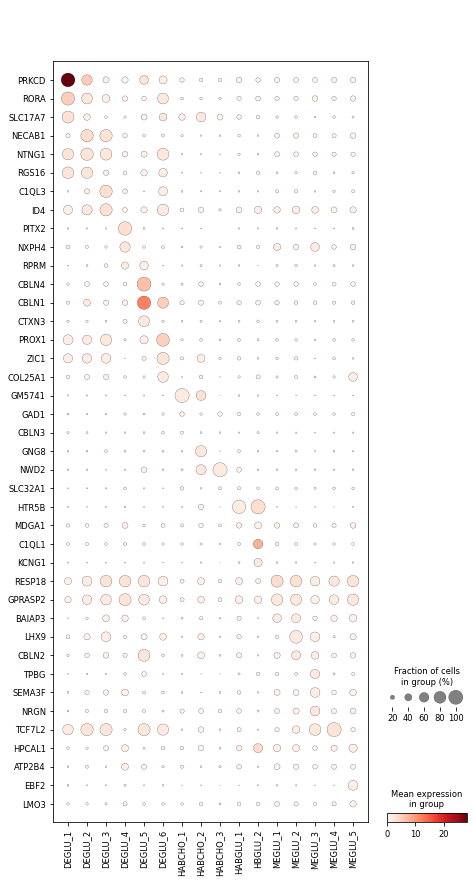

In [ ]:
markers_apper=[]
for i in markers:
    if i not in markers_apper:
        markers_apper.append(i)        
        
        
axes=sc.pl.dotplot(adata_sub, markers_apper, 
                   groupby='Rank5_Symbol', swap_axes=True,return_fig=True)
axes.savefig('DotPlot_full.png',dpi = 300)